# Labour effects of temperature change by country (is now indicator 1.4 in 2018 edition)

1.3 Labour capacity

- Australia
- Brazil
- Canada
- China
- EU28
- France
- Germany
- India
- Spain
- Sweden
- UK/GB
- USA (Hawaii? Alaska? -> check with country author)

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

from tqdm import tqdm_notebook

import population_tools

from config import (DATA_SRC, POP_DATA_SRC)

In [2]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2018/countries/1.3 labour')

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/countries_rasters/*.nc'

# LIMIT to the following countries for now
# SELECTED_COUNTRIES = ['IND', 'USA', 'GBR', 'FRA', 'SWE', 'AUS', 'BRA', 'CHN', 'CAN', 'ESP']
SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL', 'PK']

## Load country data

In [3]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))

In [4]:
COUNTRIES_NAMES = COUNTRIES.set_index('iso_a2').sovereignt
COUNTRIES_NAMES['EU'] = 'EU28'

In [13]:
COUNTRIES_RASTER = xr.open_mfdataset(str(COUNTRY_RASTER_FILES))

## Load labour capacity data

In [6]:
labour_losses = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'labour_capacity_loss'/ '*.nc'),
                 concat_dim='year'
                 )

In [7]:
labour_losses['total'] = labour_losses.agriculture + labour_losses.industry + labour_losses.service

In [17]:
# Global results for reference
total_loss_sectors = pd.read_excel(Path('./results/lancet2018/global/1.3 labour') /'total loss across sectors.xlsx').set_index('year')

In [14]:
results = []

# for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
for iso_a2 in tqdm_notebook(COUNTRIES_NAMES.keys()):
    
    if iso_a2 in  COUNTRIES_RASTER.iso_a2.values:
        country_mask = COUNTRIES_RASTER.sel(iso_a2=iso_a2, drop=True).country_mask
        country_losses = labour_losses * country_mask
        country_losses = country_losses.sum(dim=['latitude', 'longitude'], skipna=True)
        country_losses['country'] = iso_a2
        results.append(country_losses)

results = xr.concat(results, dim='country').compute()

In [18]:
# Create excel file with each sheet being one of the sectors, columns for countries, rows for years
with pd.ExcelWriter(RESULTS_FOLDER / 'labour_loss_hours_by_country.xlsx') as writer:
    results.agriculture.to_series().unstack().T.to_excel(writer, sheet_name='agriculture')
    results.industry.to_series().unstack().T.to_excel(writer, sheet_name='industry')
    results.service.to_series().unstack().T.to_excel(writer, sheet_name='service')
    results.total.to_series().unstack().T.to_excel(writer, sheet_name='total')
    
    total_loss_sectors.to_excel(writer, sheet_name='global reference')


### Plot the results as area plots for each country

In [15]:
LABOUR_LOSS_PLOTS = RESULTS_FOLDER / 'labour_loss_plots'
LABOUR_LOSS_PLOTS.mkdir(exist_ok=True)

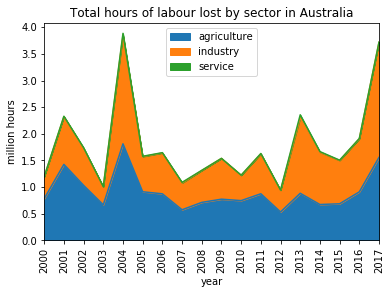

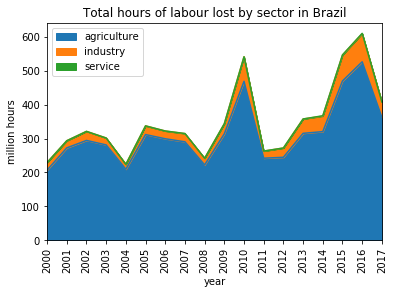

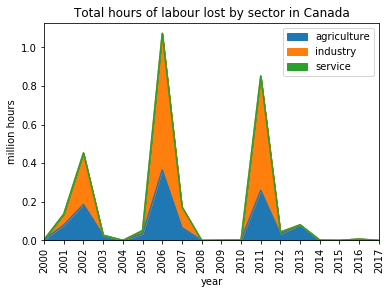

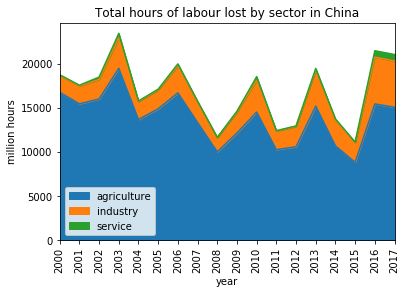

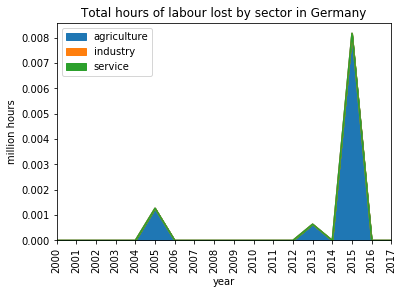

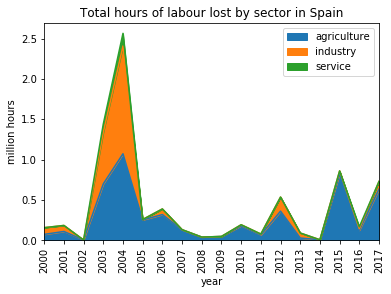

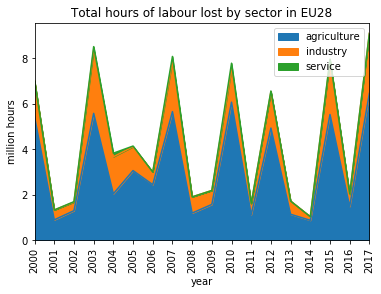

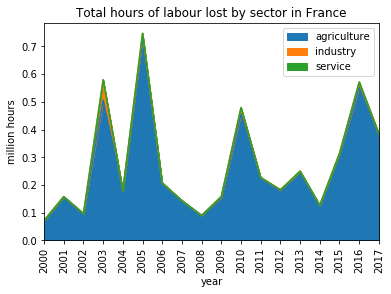

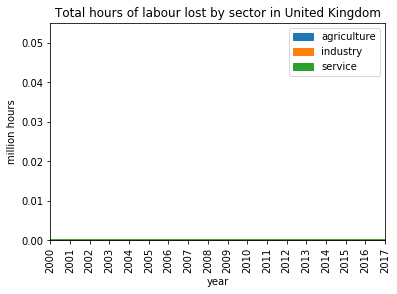

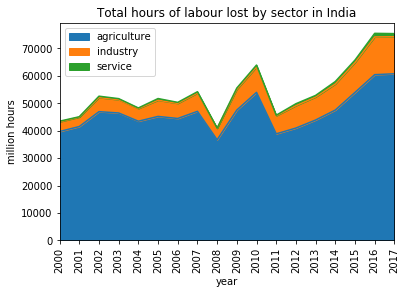

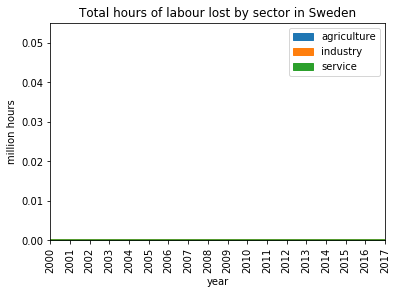

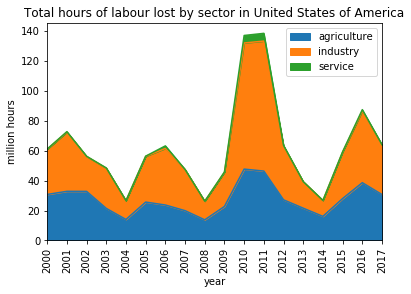

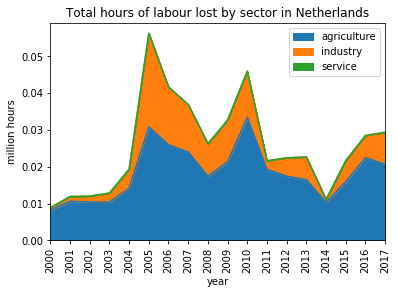

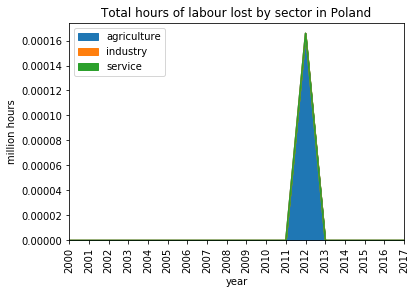

In [16]:
for h in results.country:
    h = np.asscalar(h)
    
    country_name = COUNTRIES_NAMES[h] 
    total_loss_sectors = results.sel(country=h, drop=True).to_dataframe()
    t = total_loss_sectors / 1_000_000
    ax = t[['agriculture', 'industry', 'service']].plot.area()
    ax.set_ylabel('million hours')

    plt.title(f'Total hours of labour lost by sector in {country_name}')
    plt.xlim(2000, 2017)
    plt.xticks(t.index, rotation=90)


    plt.savefig(LABOUR_LOSS_PLOTS / f'{h}_total_labour_loss_by_sector_area.png', 
                bbox_inches='tight', dpi=300)


## (Optional) Maps

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


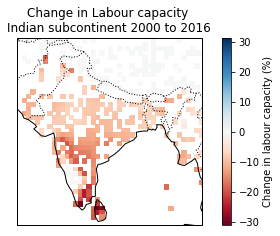

In [24]:
labour_losses

year_data = labour_losses.sel(year=2016)


year_data = year_data * population_tools.get_water_mask(year_data)
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='Change in labour capacity (%)'),
                          cmap='RdBu'
                         )
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

ax.set_extent((66.18,98.3,5.32, 36.91))
ax.coastlines()
plt.tight_layout()
plt.title('''Change in Labour capacity 
Indian subcontinent 2000 to 2016''')


f.savefig(COUNTRY_BRIEFS / 'india'/ 'labour_capacity_delta_change_2000-2016.png', dpi=300, bbox_inches='tight')
# f.savefig('labour_capacity_delta_change_2000-2016.pdf')